In [ ]:
# import tensorflow as tf

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [2]:
# os.chdir("/mnt/")
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
from scipy.io import loadmat

import matplotlib.pyplot as plt

In [5]:
!git clone https://github.com/Annaantonin/Data.git

fatal: destination path 'Data' already exists and is not an empty directory.


In [125]:
rm -rf Data

In [ ]:
# !git clone https://github.com/Crunch-UQ4MI/neuraluq.git

In [4]:
import Data as data
# data = sio.loadmat("Data/sdof_2000.mat")

In [ ]:
!git clone https://github.com/Crunch-UQ4MI/neuraluq.git
#!git clone https://github.com/Annaantonin/Data.git
!pip install tensorflow-probability
!pip install scipy
import os
# os.chdir("/tf/neuraluq/")
!python setup.py install

In [ ]:
os.listdir(".")

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  4 16:14:30 2023

@author: Antonina
"""

#%%
# Simulated SDOF with:
#K_true=10;
# C_true=0.2236; %system damping ratio 5%

# m=5; %mass for sdof example

def load_data(noise):

    #data = sio.loadmat(r"G:\My Drive\Python_codes\NNs\sdof_ymeas.mat")
    # data = sio.loadmat("Data/sdof_noforce.mat")
    data = sio.loadmat("Data/sdof_noforce.mat")
    #  t_x_train, t_f_train = data["t"], data["ymeas"]
    # data = matdata['data']
    x_tt_train, t_train = data["a"], data["t"]
    x_train, f_train = data["u"], data["U"]
    # Input_train=t, x_tt
    # train_x_tt = t_x_tt_train, x_train
    # train_f = t_f_train, f_train

    return  x_tt_train, t_train.T, x_train, f_train

#m=1
# [0][..., 0:1]     

def pde_fn(t, x, f, log_c, log_k):
    m=5
    # k=10
    # c=3.11
    # log_k=tf.clip_by_value(log_k,np.log(0),np.log(20)) # to make constrains for the parameters
    # log_c=tf.clip_by_value(log_c,np.log(0),np.log(0.5))
    x_t = tf.gradients(x, t)      [0] [..., 0:1]     #velocity                                                                                                                                                                                                                   
    x_tt = tf.gradients(x_t, t)   [0] [..., 0:1] 

    # f = m*x_tt+c*x_t+k*x
    x_tt=(f-tf.exp(log_c)*x_t - tf.exp(log_k) * x)/m
    # return [f,x_tt]
    return x_tt

def pde_xtt(t,x):
    x_t = tf.gradients(x, t)       [0] #[..., 0:1]                                                                                                                                                                                                                 
    x_tt = tf.gradients(x_t, t)    [0] #[..., 0:1]
    return x_tt

def pde1_init(init,x):
    x0=10
    return x0-x[0]

def pde2_init(t, x):
    x_t = tf.gradients(x, t)   [0] [..., 0:1] 
    # vel=-0.0997   
    vel=0
    return vel-x_t[0]
    
@neuq.utils.timer
def Trainable(
   x_tt_train, t_train, x_train, f_train, noise, layers, 
):
    # build processes
    
    process_x = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        # surrogate=neuq.surrogates.FNN(layers=layers,activation=RELu),
        posterior=neuq_vars.fnn.Trainable(layers=layers),# displacement
    )
         # posterior=neuq_vars.fnn.Trainable(
         #    layers=layers, regularizer=tf.keras.regularizers.l2(1e-5)
        # ),
    # )
    process_f = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        # surrogate=neuq.surrogates.FNN(layers=layers,activation=RELu),
        posterior=neuq_vars.fnn.Trainable(layers=layers),# displacement
     )
   
    process_log_c = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_log_k = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=10000, optimizer=tf.train.AdamOptimizer(1e-3),
    )

    # build losses
    loss_f = neuq.likelihoods.MSE(
        inputs=t_train,
        # targets=f_train, # minimizing the loss to be close to zero
        targets=x_tt_train, # minimizing the loss to be close to zero
        processes=[process_x, process_f, process_log_c, process_log_k], # tf train
        pde=pde_fn,
        multiplier=1,
    )
   
    loss_x = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train, # could be the problem
        processes=[process_x],
        pde=pde_xtt, # dotdot _X
        multiplier=1,
    )
       

    loss1_init = neuq.likelihoods.MSE(
        inputs=np.zeros_like(t_train),
        targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
         # targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
        processes=[process_x], # tf train
        pde=pde1_init,
        multiplier=1,
    )   

    loss2_init = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
         # targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
        processes=[process_x], # tf train
        pde=pde2_init, # seem to worsen the predictions and the fit
        multiplier=1,
    )   

    # build model
    model = neuq.models.Model(
        processes=[process_x, process_f, process_log_c, process_log_k],
        likelihoods=[loss_x, loss_f, loss1_init, loss2_init],
    )
    # assign and compile method
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    # samples,results = model.run()
    # print("Acceptance rate: %.3f \n" % (np.mean(results)))
    
    processes = [process_x, process_f, process_log_c, process_log_k]
    likelihoods=[loss_x, loss_f, loss1_init, loss2_init]
    return processes, samples, model, likelihoods


if __name__ == "__main__":

    noise = 0

    x_tt_train, t_train, x_train, f_train = load_data(noise)

    # t_x_tt_train, x_tt_train = train_x_tt
    # t_f_train, f_train = train_f

    layers = [1,100,100,1]

    processes, samples, model, likelihoods = Trainable( x_tt_train, t_train, x_train, f_train, noise, layers,  )

    (x_pred, f_pred, logc_pred, logk_pred)= model.predict(t_train, samples, processes, pde_fn=None)
    


2023-12-19 13:10:22.224992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 13:10:22.225050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 13:10:22.225059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 13:10:22.225220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 13:10:22.225230: I tensorflow/compile

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...


2023-12-19 13:10:22.624763: W tensorflow/c/c_api.cc:305] Operation '{name:'Variable_13/Assign' id:100 op device:{requested: '', assigned: ''} def:{{{node Variable_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_13, Const_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  131.93913
Iteration:  1000 , loss:  2.7557726
Iteration:  2000 , loss:  1.7367238
Iteration:  3000 , loss:  0.8334429
Iteration:  4000 , loss:  0.275072
Iteration:  5000 , loss:  0.040426675
Iteration:  6000 , loss:  0.022668313
Iteration:  7000 , loss:  0.019074727
Iteration:  8000 , loss:  0.013214987
Iteration:  9000 , loss:  0.008483087
Generating 1th sample by deep ensemble...
Iteration:  0 , loss:  131.8386


2023-12-19 13:10:51.217944: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  3.1467645
Iteration:  2000 , loss:  1.7698687
Iteration:  3000 , loss:  0.9261373
Iteration:  4000 , loss:  0.2026272
Iteration:  5000 , loss:  0.04378416
Iteration:  6000 , loss:  0.033743683
Iteration:  7000 , loss:  0.023508899
Iteration:  8000 , loss:  0.012003948
Iteration:  9000 , loss:  0.006460865
Generating 2th sample by deep ensemble...
Iteration:  0 , loss:  132.03365


2023-12-19 13:11:20.612390: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.824587
Iteration:  2000 , loss:  1.6982415
Iteration:  3000 , loss:  1.1471453
Iteration:  4000 , loss:  0.3113517
Iteration:  5000 , loss:  0.042188097
Iteration:  6000 , loss:  0.024222374
Iteration:  7000 , loss:  0.01995575
Iteration:  8000 , loss:  0.0138900345
Iteration:  9000 , loss:  0.011056932
Generating 3th sample by deep ensemble...
Iteration:  0 , loss:  131.89587


2023-12-19 13:11:48.883928: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.8570132
Iteration:  2000 , loss:  1.6949942
Iteration:  3000 , loss:  1.3502523
Iteration:  4000 , loss:  0.21978971
Iteration:  5000 , loss:  0.050322596
Iteration:  6000 , loss:  0.03485908
Iteration:  7000 , loss:  0.028590726
Iteration:  8000 , loss:  0.018637931
Iteration:  9000 , loss:  0.014050148
Generating 4th sample by deep ensemble...
Iteration:  0 , loss:  131.89417


2023-12-19 13:12:19.299904: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.902905
Iteration:  2000 , loss:  1.8296599
Iteration:  3000 , loss:  1.4087267
Iteration:  4000 , loss:  0.32290837
Iteration:  5000 , loss:  0.053226363
Iteration:  6000 , loss:  0.032157734
Iteration:  7000 , loss:  0.02352533
Iteration:  8000 , loss:  0.019406158
Iteration:  9000 , loss:  0.016222073
Generating 5th sample by deep ensemble...
Iteration:  0 , loss:  131.88812


2023-12-19 13:12:48.320050: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.3592756
Iteration:  2000 , loss:  1.0071644
Iteration:  3000 , loss:  0.5722877
Iteration:  4000 , loss:  0.12356796
Iteration:  5000 , loss:  0.035368398
Iteration:  6000 , loss:  0.023977773
Iteration:  7000 , loss:  0.01626905
Iteration:  8000 , loss:  0.011469877
Iteration:  9000 , loss:  0.008107761
Generating 6th sample by deep ensemble...
Iteration:  0 , loss:  131.90248


2023-12-19 13:13:15.985064: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.5986395
Iteration:  2000 , loss:  1.6102543
Iteration:  3000 , loss:  0.881963
Iteration:  4000 , loss:  0.32761863
Iteration:  5000 , loss:  0.047504026
Iteration:  6000 , loss:  0.02945875
Iteration:  7000 , loss:  0.023369461
Iteration:  8000 , loss:  0.01889417
Iteration:  9000 , loss:  0.014793221
Generating 7th sample by deep ensemble...
Iteration:  0 , loss:  131.92764


2023-12-19 13:13:43.306018: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.9155364
Iteration:  2000 , loss:  1.7996117
Iteration:  3000 , loss:  0.6495964
Iteration:  4000 , loss:  0.07904958
Iteration:  5000 , loss:  0.030330999
Iteration:  6000 , loss:  0.025257662
Iteration:  7000 , loss:  0.010546448
Iteration:  8000 , loss:  0.009047452
Iteration:  9000 , loss:  0.008159867
Generating 8th sample by deep ensemble...
Iteration:  0 , loss:  131.84201


2023-12-19 13:14:09.844791: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.7942648
Iteration:  2000 , loss:  1.720736
Iteration:  3000 , loss:  0.6047155
Iteration:  4000 , loss:  0.14959505
Iteration:  5000 , loss:  0.032168396
Iteration:  6000 , loss:  0.018963393
Iteration:  7000 , loss:  0.014432631
Iteration:  8000 , loss:  0.011704777
Iteration:  9000 , loss:  0.010150284
Generating 9th sample by deep ensemble...
Iteration:  0 , loss:  131.86133


2023-12-19 13:14:37.083096: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  3.2170043
Iteration:  2000 , loss:  1.9171456
Iteration:  3000 , loss:  1.5037204
Iteration:  4000 , loss:  0.8014598
Iteration:  5000 , loss:  0.14108445
Iteration:  6000 , loss:  0.028176887
Iteration:  7000 , loss:  0.020050678
Iteration:  8000 , loss:  0.015348615
Iteration:  9000 , loss:  0.012262376
Generating 10th sample by deep ensemble...
Iteration:  0 , loss:  131.8519


2023-12-19 13:15:03.385021: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.8404436
Iteration:  2000 , loss:  1.7566187
Iteration:  3000 , loss:  0.6325696
Iteration:  4000 , loss:  0.10014615
Iteration:  5000 , loss:  0.0353001
Iteration:  6000 , loss:  0.025526265
Iteration:  7000 , loss:  0.015044674
Iteration:  8000 , loss:  0.010690134
Iteration:  9000 , loss:  0.00884217
Generating 11th sample by deep ensemble...
Iteration:  0 , loss:  131.84828


2023-12-19 13:15:30.315434: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.8324513
Iteration:  2000 , loss:  1.7252228
Iteration:  3000 , loss:  0.77637637
Iteration:  4000 , loss:  0.17574115
Iteration:  5000 , loss:  0.03909448
Iteration:  6000 , loss:  0.014136074
Iteration:  7000 , loss:  0.005149532
Iteration:  8000 , loss:  0.003927059
Iteration:  9000 , loss:  0.0031444381
Generating 12th sample by deep ensemble...
Iteration:  0 , loss:  131.8357


2023-12-19 13:16:02.354037: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.875059
Iteration:  2000 , loss:  1.6022971
Iteration:  3000 , loss:  0.4216901
Iteration:  4000 , loss:  0.0703561
Iteration:  5000 , loss:  0.037641607
Iteration:  6000 , loss:  0.03186795
Iteration:  7000 , loss:  0.032610178
Iteration:  8000 , loss:  0.028565899
Iteration:  9000 , loss:  0.027941143
Generating 13th sample by deep ensemble...
Iteration:  0 , loss:  131.82149


2023-12-19 13:16:30.211723: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.747851
Iteration:  2000 , loss:  1.7404059
Iteration:  3000 , loss:  0.85947293
Iteration:  4000 , loss:  0.07884604
Iteration:  5000 , loss:  0.010155945
Iteration:  6000 , loss:  0.006050679
Iteration:  7000 , loss:  0.005110926
Iteration:  8000 , loss:  0.0044323537
Iteration:  9000 , loss:  0.0039594057
Generating 14th sample by deep ensemble...
Iteration:  0 , loss:  131.86276


2023-12-19 13:16:59.916634: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.7483168
Iteration:  2000 , loss:  1.7551156
Iteration:  3000 , loss:  0.9555617
Iteration:  4000 , loss:  0.5813291
Iteration:  5000 , loss:  0.06494467
Iteration:  6000 , loss:  0.033477124
Iteration:  7000 , loss:  0.024063032
Iteration:  8000 , loss:  0.018080998
Iteration:  9000 , loss:  0.022138702
Generating 15th sample by deep ensemble...
Iteration:  0 , loss:  131.80626


2023-12-19 13:17:30.031571: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  3.0634146
Iteration:  2000 , loss:  1.9015862
Iteration:  3000 , loss:  0.8336151
Iteration:  4000 , loss:  0.09665429
Iteration:  5000 , loss:  0.03618692
Iteration:  6000 , loss:  0.031578083
Iteration:  7000 , loss:  0.029521517
Iteration:  8000 , loss:  0.028596547
Iteration:  9000 , loss:  0.028040418
Generating 16th sample by deep ensemble...
Iteration:  0 , loss:  131.8836


2023-12-19 13:17:59.267018: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.7292314
Iteration:  2000 , loss:  1.686184
Iteration:  3000 , loss:  1.0150713
Iteration:  4000 , loss:  0.13211109
Iteration:  5000 , loss:  0.041820575
Iteration:  6000 , loss:  0.03082847
Iteration:  7000 , loss:  0.028665423
Iteration:  8000 , loss:  0.026388995
Iteration:  9000 , loss:  0.024627974
Generating 17th sample by deep ensemble...
Iteration:  0 , loss:  131.82733


2023-12-19 13:18:28.570765: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.3647947
Iteration:  2000 , loss:  1.2347183
Iteration:  3000 , loss:  0.54399186
Iteration:  4000 , loss:  0.11432652
Iteration:  5000 , loss:  0.043880537
Iteration:  6000 , loss:  0.036538027
Iteration:  7000 , loss:  0.032230344
Iteration:  8000 , loss:  0.03141053
Iteration:  9000 , loss:  0.030684814
Generating 18th sample by deep ensemble...
Iteration:  0 , loss:  131.8468


2023-12-19 13:18:56.342408: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.9764056
Iteration:  2000 , loss:  1.6915126
Iteration:  3000 , loss:  0.61220783
Iteration:  4000 , loss:  0.13769545
Iteration:  5000 , loss:  0.036053058
Iteration:  6000 , loss:  0.022013623
Iteration:  7000 , loss:  0.01686367
Iteration:  8000 , loss:  0.013459463
Iteration:  9000 , loss:  0.012224806
Generating 19th sample by deep ensemble...
Iteration:  0 , loss:  131.86093


2023-12-19 13:19:24.239945: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node beta2_power/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power, beta2_power/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  2.8437471
Iteration:  2000 , loss:  1.3951842
Iteration:  3000 , loss:  0.9636002
Iteration:  4000 , loss:  0.20497377
Iteration:  5000 , loss:  0.03772964
Iteration:  6000 , loss:  0.01999759
Iteration:  7000 , loss:  0.014053013
Iteration:  8000 , loss:  0.010899937
Iteration:  9000 , loss:  0.00930771
Execution time for 'Trainable' function is: 569.138 s, 9.486 mins


In [ ]:
# (xtt_pred, )= model.predict(t_train,samples, processes, pde_fn=pde_xtt)

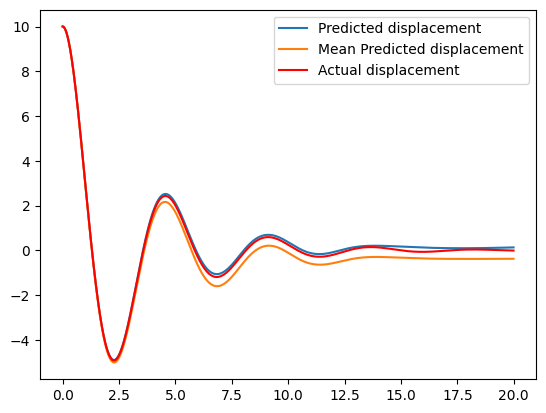

In [10]:
plt.plot(t_train, x_pred[9,:,0].flatten(),label='Predicted displacement')
plt.plot(t_train,np.mean(x_pred,axis=(0, 2)),label='Mean Predicted displacement')
plt.plot(t_train, x_train,'r',label='Actual displacement')
plt.legend()

In [ ]:
plt.plot(t_train,np.mean(f_pred,axis=(0, 2)),label='Predicted force')
plt.plot(t_train,f_train,'r',label='Actual force')
plt.legend()

In [11]:
f_pred= np.mean(f_pred, axis=0)
MSE_f= np.mean((f_train - f_pred) ** 2)
print('MSE_f=', MSE_f)

MSE_f= 12.090184


In [ ]:
# (x_pred, process_log_k)= model.predict(t_train, samples, processes, pde_fn=None)
neuq.utils.hist(np.exp(logk_pred).flatten(), name="value of $k$")

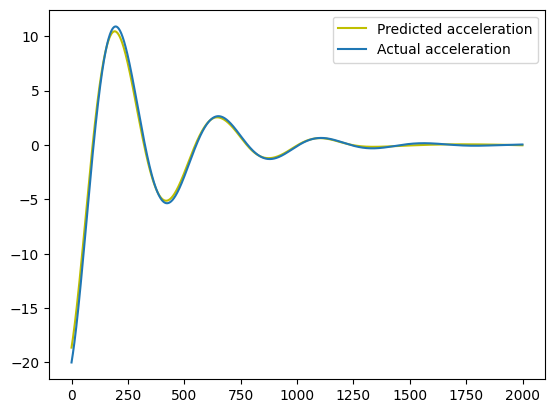

In [12]:
# print(likelihoods)
(xtt_pred,) = model.predict(t_train, samples, processes, pde_fn=pde_fn)
plt.plot(xtt_pred[9,:,0].flatten(),'y',label='Predicted acceleration')
plt.plot(x_tt_train,label='Actual acceleration')
plt.legend()

In [178]:
f_pred.shape
x_pred.shape

(10, 2000, 1)

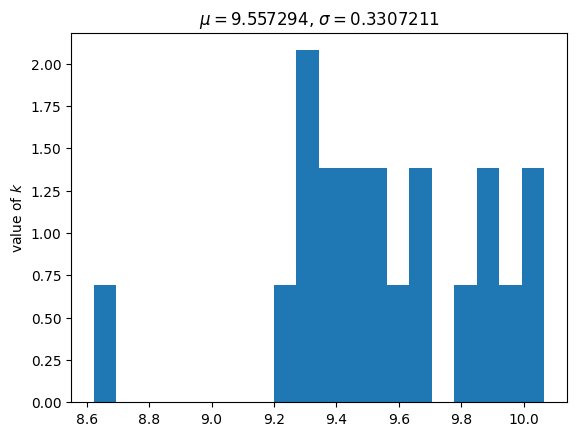

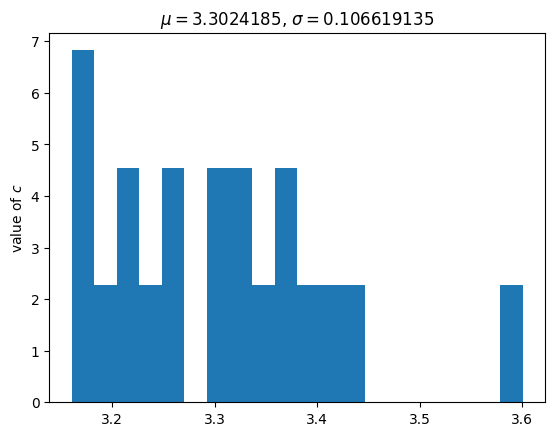

In [7]:
neuq.utils.hist(np.exp(logk_pred).flatten(), name="value of $k$")
neuq.utils.hist(np.exp(logc_pred).flatten(), name="value of $c$")

In [ ]:
(xtt_pred,) = model.predict(t_train, samples, processes, pde_fn=pde_xtt)

In [14]:
x = np.mean(x_pred, axis=0)
# x=x_pred[9,:,0].flatten()
MSE_x= np.mean((x_train - x) ** 2)
print('MSE_x=',MSE_x)

MSE_x= 0.11503302840397306


In [15]:
xtt = np.mean(xtt_pred, axis=0)
MSE_xtt= np.mean((x_tt_train - xtt) ** 2)
print('MSE_xtt=',MSE_xtt)

MSE_xtt= 0.035109642188794865


[[0.00094493]
 [0.00096419]
 [0.00098649]
 ...
 [0.4719459 ]
 [0.47187787]
 [0.47181004]]


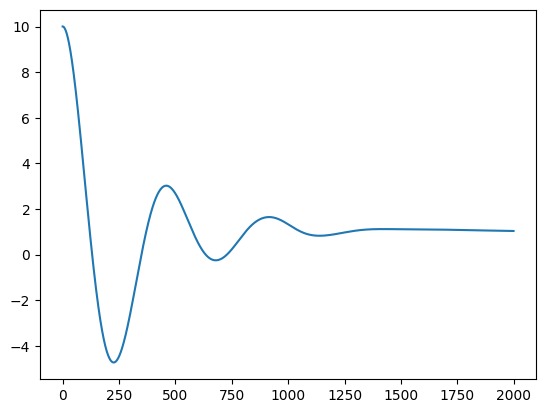

In [16]:
mu = np.mean(x_pred, axis=0)
std = np.std(x_pred, axis=0)
print(std)
# plt.plot(std)
plt.plot(mu+3*std)

In [ ]:
# ee=x-x_train
# MSE_x=mse(x_train, x)
# print(MSE_x)
# plt.plot(ee)
# (x).shape
# # x_train.shape
# plt.plot(ee)
# plt.plot(x_train)

In [ ]:
Csamp=samples[6]    
Ksamp=samples[7]
C_post=np.exp(np.mean(Csamp))
print("C_true=0.22(Ns/m) and C_post =", C_post) 
K_post=np.exp(np.mean(Ksamp))
print("K_true=10(N/m) and K_post =", K_post)

In [ ]:
# sio.savemat("G:/My Drive/Python_codes/sdof0.mat", {"x_pred":x_pred, "k":samples[7].flatten(),"c":samples[6].flatten()})

In [ ]:
plt.plot(x_tt_train)

In [ ]:
# loss_pde= model.predict(t_train, samples, processes, pde_fn=pde_fn)

loss_x =